# Amazon Instruments

Author: Leandro Hornos

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("white")
sns.set_palette("mako_r")

In [2]:
# Import the dataset
df = pd.read_csv("Musical_instruments_reviews.csv")

# The json file contains the same info as the csv:
# reviews = pd.read_json("Musical_Instruments_5.json")

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [5]:
df.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

It can be seen that we have several missing names. Clearly, names are not relevant to the kind of analysis that we want to perform and, therefore, we can drop that column and forget about the nulls. On the other hand, we have a few missing reviews. 

In [6]:
df.reviewerName.fillna(df.reviewerID, inplace=True)
df.reviewText.fillna("", inplace=True)

In [7]:
# It would be interesting to take a look at the general look of the reviews
# The next function prints n random comments

import random

def printRandomComments(df, number=10):
    for i in range(0,number):
        j = random.randint(0, df.shape[0])
        print(str(i+1)+") "+df["reviewText"][j]+"\n")
        i=i+1

printRandomComments(df, 5)

1) No complaints at all. I use this for vocals and recording acoustic through a Pod Studio UX2. Have had tons of compliments on the sound. People can't belive its a 50 dollar mic when I tell them. Such a fantastic price on this, can't beat it.

2) I gig a lot and since I am a grey haired musician I need to sit when it will be over an hour of playing. This seat works great for me and folds up and can be disassembled with very little fuss. The back rest support is nice, too. For the price its well constructed and perfect for the solo musician doing gigs all over the country.

3) This polish was recommended in one of Dan Erlewine's books and it works great.  It really makes the natural high gloss finish on acoustic guitars pop.  The effect isn't as noticeable on darker finishes though.  It really helps on the back of the neck too, makes it slippery and fast.  Highly recommended.

4) These strings last a good long time and are rather inexpensive. the tone is clear and bright. I have used D

## Sentiment Analysis

In [8]:
from textblob import TextBlob
from wordcloud import WordCloud

We are going to use textblob to get the subjectivity and polarity values of each review text, and we are going to use those values to clasify them as positive, neutral or negative

In [9]:
# We define a function for each value an create add them to new columns

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolatiry(text):
    return TextBlob(text).sentiment.polarity

# Getting all the values takes time so the next lines help with anxiety
start_time = time.time()
print("Performing analysis...")

# Get the values and fill the columns
df["Subjectivity"] = df["reviewText"].apply(getSubjectivity)
df["Polarity"] = df["reviewText"].apply(getPolatiry)

print("Analysis concluded in "+"%s seconds" % (time.time() - start_time))
df[["reviewText", "Subjectivity","Polarity"]].head()

Performing analysis...
Analysis concluded in 20.059217929840088 seconds


,reviewText,Subjectivity,Polarity
0,"Not much to write about here, but it does exac...",0.398611,0.250000
1,The product does exactly as it should and is q...,0.394444,0.052778
2,The primary job of this device is to block the...,0.434286,0.167500
3,Nice windscreen protects my MXL mic and preven...,0.925000,0.200000
4,This pop filter is great. It looks and perform...,0.750000,0.800000


In [10]:
# Now let's clasify the reviews based on ther polarity score

# This function asigns a label based on the score
# If no limits are pased, positive and negative labels will be based on the sign
# if ranges are pased, values within those ranges are going to be consider neutral

def assignSentiment(score, thresholds=[0,0]):
    if score < thresholds[0]:
        return "Negative"
    elif score > thresholds[1]:
        return "Positive"
    else:
        return "Neutral"

df["Sentiment"] = df["Polarity"].apply(lambda x: assignSentiment(x, [-0.1,0.1]))

In [11]:
pd.DataFrame(df["Sentiment"].value_counts()).rename(columns={"Sentiment":"Reviews"})

,Reviews
Positive,8283
Neutral,1705
Negative,273


### WordCloud

In [12]:
# Let's create some filters based on the asigned sentiments

pos = df["Sentiment"] == "Positive"
neu = df["Sentiment"] == "Neutral"
neg = df["Sentiment"] == "Negative"


# we define a function to give as a wordcloud from a given text

def showWordCloud(text):
    wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=120).generate(text)
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.show()

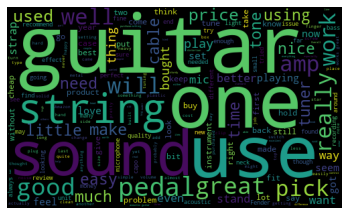

In [13]:
# All Reviews
allReviews = "".join(msgs for msgs in df["reviewText"])    
showWordCloud(allReviews)

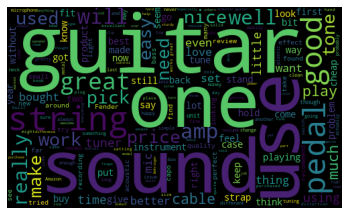

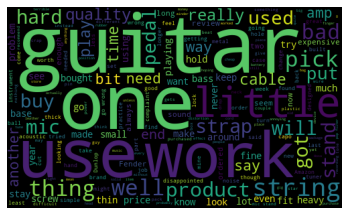

In [18]:
# Positive Reviews
posReviews = "".join(msgs for msgs in df[pos]["reviewText"])    
showWordCloud(posReviews)

# Negative
negReviews = "".join(msgs for msgs in df[neg]["reviewText"])    
showWordCloud(negReviews)

In [19]:
# It seems tha "guitar", "one" is pretty prevalent, let's remove those words

def removeSubstrings(text,substrings=[""]):
    text = text.lower()
    for substr in substrings:
        text = text.replace(substr.lower(),"")
    return text       

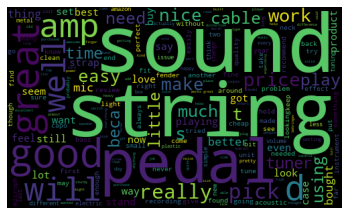

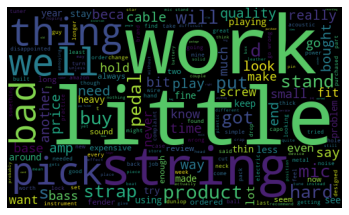

In [20]:
to_remove = ["guitar", "one","use"]
posReviews = removeSubstrings(posReviews, to_remove)     
negReviews = removeSubstrings(negReviews, to_remove)

showWordCloud(posReviews)
showWordCloud(negReviews)